| Description    | Salla recruitment test ML Ops |
| -------- | ------- |
| Author  | Muhammad Waheed ud din Siddiqui    |
| Online link |      |
| Date    | 19th Oct 2024    |

In [1]:
## import necessary libraries for data manipultaion
import numpy as np
import pandas as pd

## import libraries for graph plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as py
import matplotlib.gridspec as gridspec

## import model training and evaluating libraries
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## import various model architectures
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline as sklearn_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
## import and set support libraries
import warnings
warnings.filterwarnings('ignore', category=UserWarning) 
import time
%matplotlib inline



### Reading the data:
The data is read locally and a few observations are made about the data.

In [2]:
## reading the data
original_data_df = pd.read_csv(R"C:\work\salla_job\financial_fraud.csv")
data_df = original_data_df.copy()
print("number of rows:" + str(data_df.shape[0]))
print("number of columns:" + str(data_df.shape[1]))

## Nan values percentage
nan_count = data_df.isna().sum() > 0
nan_percentage = data_df.isna().mean().round(4) * 100
print("\nFollowing are the names of the column and the percentage of Nan vlaues in each column")
for col_name,percent_value in zip(list(nan_count.index[nan_count]) , list(nan_percentage[list(nan_count.index[nan_count])].values)):
    print(col_name + "\t\t"  + str(percent_value))

print("\nnumber of duplicated rows in the dataframe: " + str(data_df.duplicated().sum()))

print("\nWe see that all data columns are numeric by thier data type. No categorical features are present in the original data")
print(data_df.dtypes.value_counts())
data_df.head(5)


number of rows:22257
number of columns:30

Following are the names of the column and the percentage of Nan vlaues in each column
Amount		10.01

number of duplicated rows in the dataframe: 24

We see that all data columns are numeric by thier data type. No categorical features are present in the original data
float64    29
int64       1
Name: count, dtype: int64


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.059663,-0.389790,0.619460,-0.401747,0.140408,0.044106,0.437610,-0.182929,0.609347,0.578219,...,-0.223024,-0.822861,0.054543,-0.221428,0.340502,0.299070,-0.278195,-0.066949,18350.99,0
1,1.185201,-0.632161,0.507347,-0.887614,-0.069023,-0.211981,0.316608,-0.201578,0.186763,0.896861,...,-0.049555,0.317525,-0.171600,0.877552,1.172317,-0.126833,-0.258122,-0.097628,11741.12,0
2,-0.294450,-0.343103,2.636968,0.020243,-0.190241,1.136060,0.159043,0.069876,1.303589,0.360826,...,-0.061339,0.667540,-0.500019,-0.091960,0.728922,0.288978,0.065387,-0.126222,10678.90,0
3,1.008758,-0.371089,0.336378,-0.280149,0.451093,0.411290,0.566228,-0.204960,0.418702,0.576636,...,-0.107451,-0.094682,-0.364701,-1.581107,1.437732,-0.593228,-0.228128,-0.051419,4908.08,0
4,-0.207350,-0.269502,2.882598,-0.376418,0.328215,0.340967,0.474141,-0.124787,1.380252,0.129873,...,-0.064668,0.545575,-0.281799,1.282384,0.826799,-0.827908,-0.173036,0.084015,1549.61,0


As an overview of the data, it will be interesting to see the target class distributions

In [3]:
colors = ['Green', 'Red']
labels = ['Non-Fraud', 'Fraud']
data_df['Class_bool'] = data_df['Class'] > 0
values = data_df['Class'].value_counts() / data_df['Class'].shape[0]
total_normal = data_df[data_df['Class_bool'] == False].shape[0]
total_fraudulent = data_df[data_df['Class_bool'] == True].shape[0]

fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='black', width=0.1)))

fig.update_layout(
    title_text='<b>Figure 1.1: Target class distirbution in all of the data</b>',
    title_font_color='black',
    title_font=dict(size=24),
    legend_title_font_color='black',
    paper_bgcolor='lightgray',
    plot_bgcolor='lightgray',
    font_color='black',
)

fig.show()
print(values)
print(total_normal)
print(total_fraudulent)

Class
0    0.887811
1    0.112189
Name: count, dtype: float64
19760
2497


## Exploratory data analysis

In this part we will perform rudimentary EDA on the dataset to better infrom us on waht kind of data transformations or feature engineering should be done with the data.

In [4]:
## Decision about the duplicate and NA rows
only_nan_data_df = data_df[data_df.isna().any(axis=1)]
values = only_nan_data_df['Class'].value_counts() / only_nan_data_df['Class'].shape[0]
total_normal = only_nan_data_df[only_nan_data_df['Class_bool'] == False].shape[0]
total_fraudulent = only_nan_data_df[only_nan_data_df['Class_bool'] == True].shape[0]

fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='black', width=0.1)))

fig.update_layout(
    title_text='<b>Figure 1.2: Target class distirbution where the data is missing</b>',
    title_font_color='black',
    title_font=dict(size=24),
    legend_title_font_color='black',
    paper_bgcolor='lightgray',
    plot_bgcolor='lightgray',
    font_color='black',
)

fig.show()

#### Inference 1: 
While observing the dataset and the duplicate plus missing values, we observe two things:
1. the data has high imbalance in terms of the target class. 
2. The number of duplicate rows is very small as compared to the size of the dataset (less than 0.1%)
3. The 10+% of data that is missing has a target class ditribution similar to the target class distribution of the full dataset.

This means that if we deicde to drop the duplicate rows and missing values from the dataset, our overall target class distribution will not be affected. It will roughly be the same as keeping and processing the whole data. This can be checked via plotting the target class distirbutions on the redacted data as well.

So we will decide to drop the rows that have missing values. No interpolation of data to deal with missing values is needed.

In [5]:
## dropping the Nan and duplicate rows
data_df = original_data_df.copy()
data_df.drop_duplicates(keep="first",ignore_index=True,inplace=True)
data_df.dropna(inplace=True,ignore_index=True)


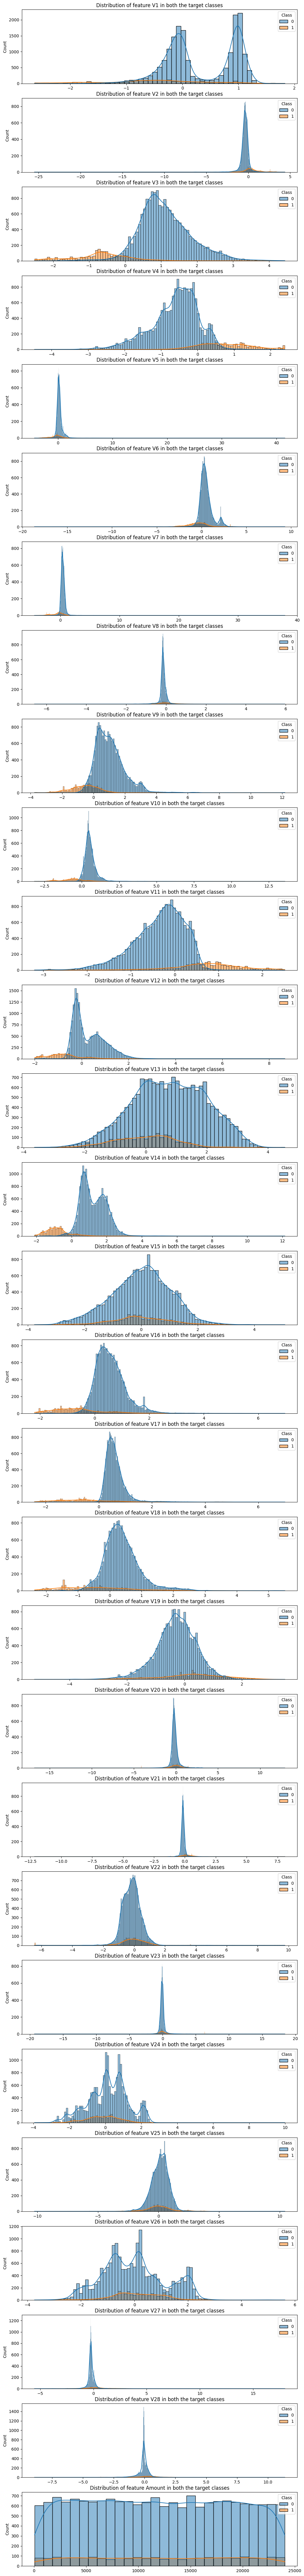

In [6]:
feature_names = list(data_df.columns)[:-1] ## the target column is excluded
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(len(feature_names), 1)
for i,col_name in enumerate(feature_names):
    ax = plt.subplot(gs[i])
    sns.histplot(data=data_df, x=col_name, kde=True,hue='Class')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature ' + col_name + ' in both the target classes')
plt.show()


#### Inference 2
Based on the distributions we plotted, we see that:
1.  Apart from the 'Amount' feature, other features in the data do not have very high or low minimum and maximum values. In fact, a lot of the features seem to be normalized already.
2.  We observe that the class based distribution for the features 'V1', 'V2', 'V5', 'V6', 'V7', 'V8', 'V13', 'V15', 'V19', 'V20' up to 'V28' and the 'Amount' has a lot of overlapping. Meaning the vlaues of these features vary in a similar way for both the target classes.
3. The features 'V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17' and 'V18' seems promising features as predictors of our target class because the target class based distributions of these features does not overlap as much as the other features.
4. No strong skewness is observed in any of the features. 'V5', 'V6', 'V7' and V10 seem to be skewed but their values are centered around 0 already. Therefore, it is less likey that using these feauters without applying any transformation will induce biasness in our model or hinder the performance of models that assume normal distribution of data.
5. Any "Amount" of transaction whether big or small is equally susceptible to a fraud. 
6. The values for the "Amount" feature vector should be normalized before use.

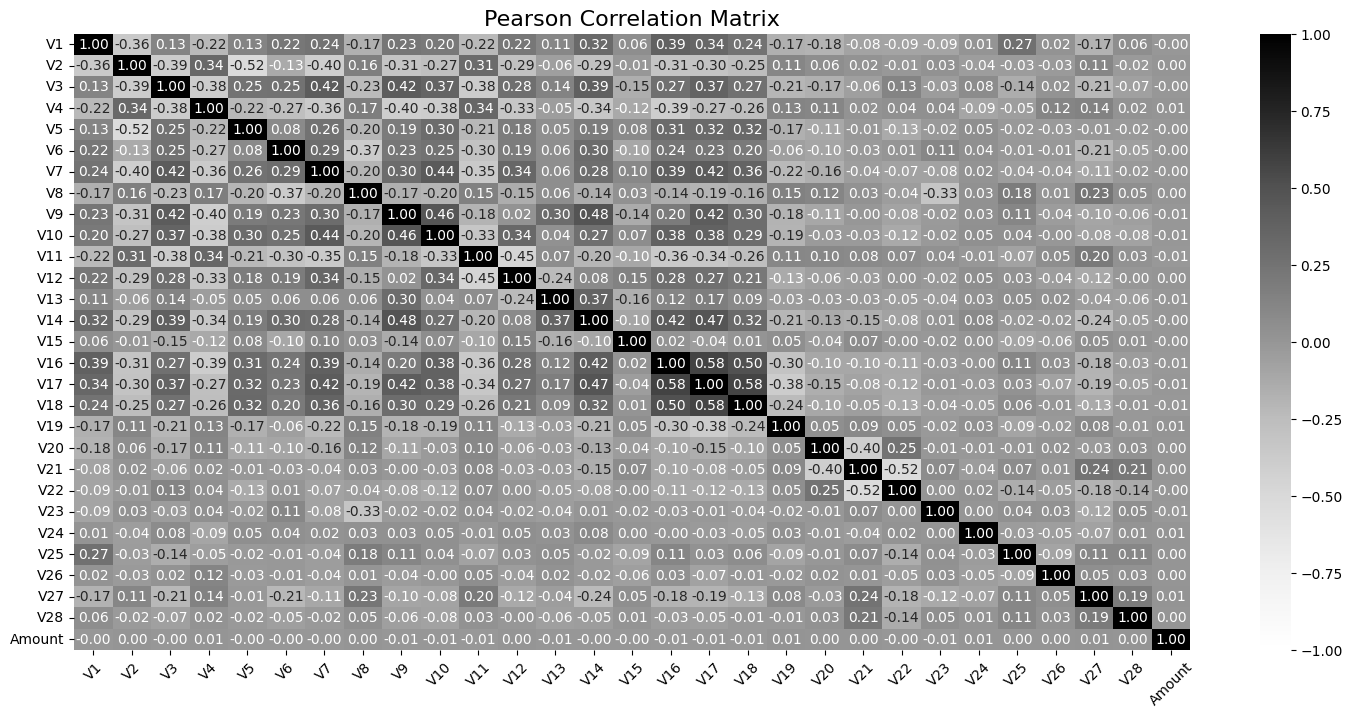

In [7]:
## pearson corrleation matrix of the numerical data
correlation = data_df[feature_names].corr()
# visulaising the correlation matrix
plt.figure(figsize=(18, 8))
sns.heatmap(correlation,vmin = -1, vmax = 1,cmap = "Greys",annot = True, fmt = '.2f')
plt.title('Pearson Correlation Matrix', fontsize=16)
plt.xticks(rotation = 45)
plt.show()



#### Inference 3:
None of the feature vectors strongly correlate (correlation value > 0.7) with each other

#### Infernece 4 - outlier analysis:
At this point, another anaylysis made should be of the outliers in the data. But, removing outliers results in losing more and more information from the data. Losing information especially in cases where there is class imbalance is not desireable.

In fact, the data distributions of feature vecotrs with respect to target classes show that important information might actually be present in the outliers themselves as many of the features have largely overlapping distributions. The non-overlaping parts of the distributions seems to be at the extremes of the data.

Therefore, we will not perform any Outlier analysis and removal of outliers from the data.

#### Inference 5 - feautre selection:
Feature Selction is not recommended at this stage. It is true that features that have overlapping distributions seem not to effect the target class. Still, in the spirit of not losing any information from the data in case of highly imabalanced target classes, we will like to keep all the features at this point in the analysis.

Later, we can rank the feature as per feature importance and see if feature removal improves the target prediction or not.

## Dataset preparation
In this section of the work, we will prepare the data with any transformations and also perform the train test split in the case of this highly imablanced classes data.

Normally, any data augmentations or cleaning is involved in this part of model development techniques as well.

#### Train test split:
It is required in the assignment to have a train test split of 95 - 5 percent ratio. It is important that the class imbalance that is present in the origianl data is mantained in both the training and test datasets.

In [8]:
data_df = original_data_df.copy()
data_df.drop_duplicates(keep="first",ignore_index=True,inplace=True)
data_df.dropna(inplace=True,ignore_index=True)

not_fraud_df = data_df[data_df['Class'] == 0].reset_index(drop=True)
fraud_df = data_df[data_df['Class'] == 1].reset_index(drop=True)

not_fraud_train_df = not_fraud_df.sample(frac=0.95,random_state=2) # random_state so that the results could be recreted again say on another machine 
not_fraud_test_df = not_fraud_df.drop(not_fraud_train_df.index)

fraud_train_df = fraud_df.sample(frac=0.95,random_state=2) # random_state so that the results could be recreted again say on another machine 
fraud_test_df = fraud_df.drop(fraud_train_df.index)

train_df = pd.concat([not_fraud_train_df,fraud_train_df],ignore_index=True)
test_df = pd.concat([not_fraud_test_df,fraud_test_df],ignore_index=True)

print("percentage size of training dataset: " + str((train_df.shape[0] / data_df.shape[0])))
print("percentage size of test dataset: " + str((test_df.shape[0] / data_df.shape[0])))

percentage size of training dataset: 0.9500249625561658
percentage size of test dataset: 0.04997503744383425


In [9]:
imbalance_in_full_data_df = data_df['Class'].value_counts() # / len(data_df)
imbalance_in_train_data_df = train_df['Class'].value_counts() # / len(train_df)
imbalance_in_test_data_df = test_df['Class'].value_counts() # / len(test_df)

class_distributions_df = pd.DataFrame(columns=["class","percentage in full data","percentage in train data","percentage in test data"])
for class_label,full_data_percentages, train_data_percentatges, test_data_percentages in zip(imbalance_in_full_data_df.index,imbalance_in_full_data_df.values,imbalance_in_train_data_df.values,imbalance_in_test_data_df.values):
    class_distributions_df.loc[len(class_distributions_df)] = {"class":class_label,"percentage in full data":full_data_percentages,
                                                               "percentage in train data":train_data_percentatges,"percentage in test data":test_data_percentages}
    
trace1 = go.Pie(
    values=list(class_distributions_df["percentage in full data"].values),
    labels=list(class_distributions_df["class"]),
    domain=dict(x=[0.0, 0.33]),
    name="count:",
    hoverinfo="value+name",
    title="full data"
)
trace2 = go.Pie(
    values=list(class_distributions_df["percentage in train data"].values),
    labels=list(class_distributions_df["class"]),
    domain=dict(x=[0.34, 0.66]),
    name="count:",
    hoverinfo="value+name",
    title="train data"
)
trace3 = go.Pie(
    values=list(class_distributions_df["percentage in test data"].values),
    labels=list(class_distributions_df["class"]),
    domain=dict(x=[0.67, 1.0]),
    name="count:",
    hoverinfo="value+name",
    title="test data"
)
layout = go.Layout(title="Equal target class distributions in train and test set as per the original data",)
plotting_data = [trace1, trace2, trace3]
fig = go.Figure(data=plotting_data, layout=layout)
fig.show()

In [10]:
## storng the train and test set on local disk
train_df.to_csv(R"./financial_fraud_training_set.csv",index=False)
test_df.to_csv(R"./financial_fraud_test_set.csv",index=False)

#### Normalization of values:
Based on "Inference 2" mentioned above, at least the "Amount" feature vector definitely needs to be normalized. I have chosen to use 'MinMaxScalar' for normalising purposes.

MinMaxScalar when created/fitted on the training set scales the data relative to the training set. This is a desireable feature as any compareable values to the values in the training dataset will be scaled by the same amount as the training dataset. Any severely unseen values will be scaled to unusally high or low values. So, i will be using MinMaxScalar on all the features and make the scalar part of the model development pipeline for easy epxorting in production.

In [11]:
## snapshot of cleaned data
train_df.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.537369,-0.794590,1.743833,0.443806,-0.064333,1.684341,0.071710,0.008737,2.297719,0.560257,...,-0.077050,0.323252,-0.396762,-1.357648,0.501705,0.570033,-0.199727,0.017921,2127.21,0
1,-0.073574,-0.117598,0.403630,-0.816298,1.601795,2.267329,0.465683,0.020471,0.225091,0.704131,...,-0.074530,-0.136673,-0.157224,2.190216,-0.288237,-1.108066,-0.645345,0.269986,13338.55,0
2,-0.048158,-0.102952,1.505077,-0.102644,0.428030,0.978739,0.569525,-0.089355,1.055942,0.500859,...,-0.142746,0.234666,-0.151246,-0.577621,-0.468274,-0.613374,0.119734,0.317618,15810.27,0
3,-0.787702,0.341799,1.859772,-1.349492,0.510946,0.289720,1.555956,-0.616160,7.558435,6.214932,...,-0.721318,-0.185176,-0.302409,0.650318,1.166953,0.245877,-0.013464,-2.199059,14026.85,0
4,-0.153829,-0.130504,1.518124,-0.953242,0.030058,-0.217554,0.504651,-0.088873,1.540897,0.106245,...,-0.149564,0.023466,-0.067173,2.127338,-0.438767,1.680020,-0.082944,0.167958,7481.18,0


## Model development:
In this section we will train a model on our prepared dataset and evaluate its performance. As the dataset is highly imbalanced, i have decided to use Area under the Curve (AUC) value of the Reciever Operating Curve (ROC) as the metirc of model performance.

F1-score and AUC-ROC are the best metrics to analyse in case of imbalanced data.

#### Baseline model:
First we will create a baseline using which we will take decisions related to model selection and model training steps. The baseline model is chosen to be a 'logistic regression' model with default hyperparameter values.

In [2]:
## reading the data again from local disk
train_df = pd.read_csv(R"C:\work\salla_job\financial_fraud_training_set.csv")
test_df = pd.read_csv(R"C:\work\salla_job\financial_fraud_test_set.csv")
target_column_name = "Class"
X_train, y_train = train_df.drop(columns=target_column_name,axis="columns"), train_df[target_column_name]
X_test, y_test = test_df.drop(columns=target_column_name,axis="columns"), test_df[target_column_name]

F1 score on test_set: 0.8910891089108911


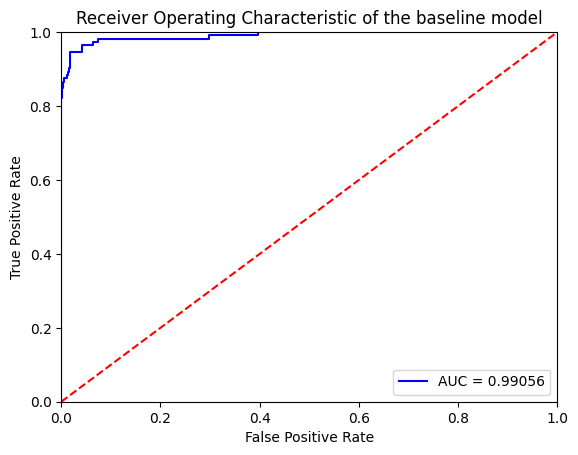

In [3]:
## Baseline model
scaler = MinMaxScaler()
logistic = LogisticRegression()
pipe = sklearn_pipeline(steps=[("scaler", scaler),("logistic", logistic)])
## Model fit and evaluate
pipe.fit(X_train, y_train)
predicted_output_test = pipe.predict(X_test)
predicted_output_train = pipe.predict(X_train)
print("F1 score on test_set: "+ str(f1_score(y_test,predicted_output_test)))

## Plottoing the ROC
probs = pipe.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic of the baseline model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#### Inference 6:
Since the class probabilites of every sklearn are not returned by default, we will check the later models on the F1 socre metric. Also, improvement in F1 is directly correlated with imporvements in AUC of the ROC so it is not a bad choice.

### Model improvements:
In order to improve the model furhter than the baseline, following startegy is used:

1. As the first idea of improvement over the baseline performance, i will try to address the data imblanaces in the training set. The class imbalance will be handled with oversampling the fraud class as any undersampling will result in loss of information. SMOTE analysis will be used to generate and balance the "Fraud" class.
2. The  training set will be further splitted into validation set before 'fitting' a model during training. This should result in avoiding any overfitting during training and may result in higher performance on the test (unseen) dataset.
3. A number of different models will be used to test for improvements against the baseline.

In [4]:
def train_and_evaluate(sklearn_model, 
                       X_training_set: pd.DataFrame,
                       y_training_set: pd.Series,
                       X_test_set: pd.DataFrame,
                       y_test_set: pd.Series,
                       n_k_folds: int=3):
    """trains a model after applying SMOTE analysis and balancing the classes in the training dataset.
       The Function uses Kfold technique to use a validation set in each training thereby reducing the chances of model overtraining.
       F1-score performance of the trained model on both the training and test dataset is also recorded 
    Parameters
    ----------
    sklearn_model : 
        The model object compatible with Sklearn library
    X_training_set : 
        Dataframe containing values of the training dataset without the target column
    y_training_set : 
        Dataseries containing values of the training dataset target column
    X_test_set : 
        Dataframe containing values of the test dataset without the target column
    y_test_set : 
        Dataseries containing values of the test dataset target column
    n_k_folds:
        The number data splits created in K-fold validation during model training

    Returns
    -------
    Tuple
        vlaue of F1 performance on training data, F1 performance on testing dataset and the trained model
        
    https://scikit-learn.org/0.19/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
    """
    pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=10)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', sklearn_model]])

    stratified_kfold = StratifiedKFold(n_splits=n_k_folds,
                                        shuffle=True,
                                        random_state=10)
    
    f1_scores = []

    X_train_numpy = X_training_set.to_numpy()
    y_train_numpy = y_training_set.to_numpy()
    X_test_numpy = X_test_set.to_numpy()
    y_test_numpy = y_test_set.to_numpy()
    i = 0
    for training_fold, validation_fold in stratified_kfold.split(X_train_numpy, y_train_numpy):
        fitted_model = pipeline.fit(X_train_numpy[training_fold], y_train_numpy[training_fold])
        predicted_output_val = fitted_model.predict(X_train_numpy[validation_fold])
        
        f1_scores.append(f1_score(y_train_numpy[validation_fold],predicted_output_val))

    mean_f1_train_set = np.mean(f1_scores,axis = 0)
    predicted_output_test = fitted_model.predict(X_test_numpy)
    test_set_f1 = f1_score(y_test_numpy,predicted_output_test)
    return mean_f1_train_set , test_set_f1, fitted_model


| Architecture choice    | Reason for training |
| -------- | ------- |
| K_NearestNeighbor  | It is a purely data based model.    |
| Logistic regression | To compare with baseline and see the affect of applying SMOTE technique|
|Ridge regression classifier| As a regression worked well on the baseline, i just wanted to try another method from regression techniques family|
|Linear Support Vecotr Machine| A data transfomration based techniques with transforms the features of the data before fitting a linear model on it.|
|RBF-kernel Support Vector Machine| The data transformation in this case is non-linear and can possibly result in better decision boundaries after the model is fitted.|
|Random Forest Ensemble| This is an ensemble technique where final decisions is a combination of multiple weak learners.|
|Shallow Neural Network| Neural Network tend to work better with numerical data and large number of features which is the case with our data.|
|XGBoost| Again an ensemble technique but the weak learners themselves are optimized using gradient descent.|

As you can see from the above table, the choice of using these models for model selection is becuase each model architecture is considerably different from eachother. Each model is candidate representation of a class of algorithms all on its own. These choices provided maximum search opportunities from variance machine learning techniques except for the Evolutionalary Algorithms based tecniques.

In [5]:
# train_and_evaluate(LogisticRegression(),X_train,y_train,X_test,y_test)

In [6]:
model_names = ["K_NearestNeighbor","Logistic regression","Ridge regression classifier","Linear Support Vecotr Machine",
               "RBF-kernel Support Vector Machine","Random Forest Ensemble","Shallow Neural Network","XGBoost"]
model_functions = [KNeighborsClassifier(),LogisticRegression(),RidgeClassifier(),LinearSVC(),SVC(),RandomForestClassifier(),MLPClassifier(),XGBClassifier()]

returned_fitted_models = []
model_selection_df = pd.DataFrame(columns=["model_name","model_f1_score_training_set","model_f1_score_test_set"])
for model_name, model_func in zip(model_names,model_functions):
    print("training model..... : " + model_name)
    start = time.time()
    f1_score_train, f1_score_test, fitted_model = train_and_evaluate(model_func,X_train,y_train,X_test,y_test)
    returned_fitted_models.append(fitted_model)
    end = time.time()
    print("training time taken: " +str(end - start) + " seconds")
    print("-----------------------------------------------------")
    
    model_selection_df.loc[len(model_selection_df)] = {"model_name":model_name,"model_f1_score_training_set":f1_score_train,
                                                       "model_f1_score_test_set":f1_score_test}
## OUTPUT:
# training model..... : K_NearestNeighbor
# training time taken: 1.0506501197814941 seconds
# -----------------------------------------------------
# training model..... : Logistic regression
# training time taken: 0.43521761894226074 seconds
# -----------------------------------------------------
# training model..... : Ridge regression classifier
# training time taken: 0.20413708686828613 seconds
# -----------------------------------------------------
# training model..... : Linear Support Vecotr Machine
# training time taken: 0.3620645999908447 seconds
# -----------------------------------------------------
# training model..... : RBF-kernel Support Vector Machine
# training time taken: 7.368047714233398 seconds
# -----------------------------------------------------
# training model..... : Random Forest Ensemble
# training time taken: 37.1556031703949 seconds
# -----------------------------------------------------
# training model..... : Shallow Neural Network
# training time taken: 141.29670238494873 seconds
# -----------------------------------------------------
# training model..... : XGBoost
# training time taken: 2.7431397438049316 seconds
# -----------------------------------------------------


training model..... : K_NearestNeighbor
training time taken: 1.0353083610534668 seconds
-----------------------------------------------------
training model..... : Logistic regression
training time taken: 0.36800575256347656 seconds
-----------------------------------------------------
training model..... : Ridge regression classifier
training time taken: 0.215559720993042 seconds
-----------------------------------------------------
training model..... : Linear Support Vecotr Machine
training time taken: 0.35103845596313477 seconds
-----------------------------------------------------
training model..... : RBF-kernel Support Vector Machine
training time taken: 7.8806328773498535 seconds
-----------------------------------------------------
training model..... : Random Forest Ensemble
training time taken: 67.84050130844116 seconds
-----------------------------------------------------
training model..... : Shallow Neural Network
training time taken: 215.56095218658447 seconds
----------

In [8]:
model_selection_df.sort_values(by="model_f1_score_test_set",ascending=False,ignore_index=True,inplace=True)
model_selection_df.to_csv(R"./model_performancces.csv",index=False)
model_selection_df
## OOUTPUT:
# model_name	model_f1_score_training_set	model_f1_score_test_set
# 0	XGBoost	0.981134	0.972727
# 1	Random Forest Ensemble	0.974106	0.963303
# 2	K_NearestNeighbor	0.937923	0.946903
# 3	Shallow Neural Network	0.941354	0.941176
# 4	Linear Support Vecotr Machine	0.917407	0.930233
# 5	RBF-kernel Support Vector Machine	0.938128	0.930233
# 6	Logistic regression	0.919641	0.920188
# 7	Ridge regression classifier	0.876528	0.876712

,model_name,model_f1_score_training_set,model_f1_score_test_set
0,XGBoost,0.981134,0.972727
1,Random Forest Ensemble,0.974531,0.968037
2,K_NearestNeighbor,0.937923,0.946903
3,Shallow Neural Network,0.947048,0.939535
4,Linear Support Vecotr Machine,0.917407,0.930233
5,RBF-kernel Support Vector Machine,0.938128,0.930233
6,Logistic regression,0.919641,0.920188
7,Ridge regression classifier,0.876528,0.876712


#### Inference 7:
AS we can see that using SMOTE technique during training results in better performance on the testing dataset. Also, the best results are given by XGBoost algorithm and because of the efficient implementation in thd XGBoost library, it is quite fast to train in comparison to other ensemble based or data hungry methods.

## Hyper parameter tuning:
In this part we will tune only the best performing "XGBoost" model to get the best performing hyperparameters for it. We will evaluate the best model trained on our testing data as well and compare with the baseline and other models trained before.

In [11]:
## reloading the data
train_df = pd.read_csv(R"C:\work\salla_job\financial_fraud_training_set.csv")
test_df = pd.read_csv(R"C:\work\salla_job\financial_fraud_test_set.csv")
target_column_name = "Class"
X_train, y_train = train_df.drop(columns=target_column_name,axis="columns"), train_df[target_column_name]
X_test, y_test = test_df.drop(columns=target_column_name,axis="columns"), test_df[target_column_name]

In [5]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=10)],
                                ['scaler', MinMaxScaler()],
                                ['xgbclassifier', XGBClassifier()]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {
    "xgbclassifier__learning_rate":[0.01, 0.3, 0.5],
    "xgbclassifier__n_estimators": [10, 100, 200],
    "xgbclassifier__max_depth": [1, 3, 5],
    'xgbclassifier__min_child_weight':[1,3,5,7],
    "xgbclassifier__objective": ["binary:logistic"],
    'xgbclassifier__gamma':[i/10.0 for i in range(0,5)],
    'xgbclassifier__lambda':[0, 0.001, 0.005, 0.01, 0.05],
    }
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

## CAUTION: takes long time to compute.
start = time.time()
grid_search.fit(X_train.to_numpy(), y_train.to_numpy())
end = time.time()
print("Hyperparameter tuning time taken: " +str(end - start) + " seconds")
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test.to_numpy(), y_test.to_numpy())
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
grid_search.best_params_
## OUTPUT:
# Hyperparameter tuning time taken: 531.75478521687329 seconds
# Cross-validation score: 0.9993450959109563
# Test score: 0.999156355455568
# {'xgbclassifier__gamma': 0.0, 
# 'xgbclassifier__lambda': 0.001, 
# 'xgbclassifier__learning_rate': 0.5, 
# 'xgbclassifier__max_depth': 3, 
# 'xgbclassifier__min_child_weight': 1, 
# 'xgbclassifier__n_estimators': 200, 
# 'xgbclassifier__objective': 'binary:logistic'}



{'xgbclassifier__gamma': 0.0, 'xgbclassifier__lambda': 0.001, 'xgbclassifier__learning_rate': 0.5, 'xgbclassifier__max_depth': 3, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__objective': 'binary:logistic'}
Cross-validation score: 0.9993450959109563
Test score: 0.999156355455568


Now that we have the best parameter set available. we just train that model and evaluate on our testing dataset

In [2]:
## reloading the data
train_df = pd.read_csv(R"C:\work\salla_job\financial_fraud_training_set.csv")
test_df = pd.read_csv(R"C:\work\salla_job\financial_fraud_test_set.csv")
target_column_name = "Class"
X_train, y_train = train_df.drop(columns=target_column_name,axis="columns"), train_df[target_column_name]
X_test, y_test = test_df.drop(columns=target_column_name,axis="columns"), test_df[target_column_name]

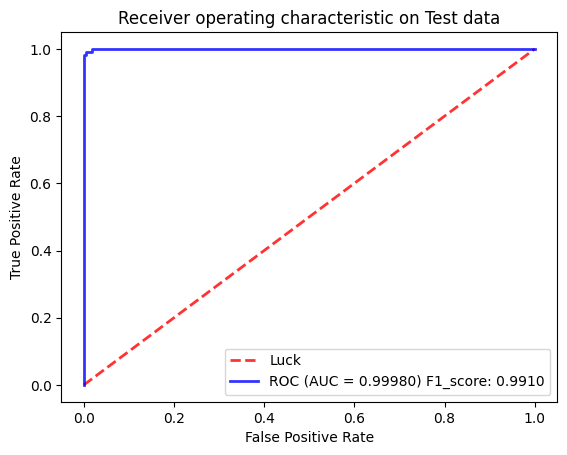

In [3]:
### Model training and evaluation
xgb_clf = XGBClassifier(objective="binary:logistic",learning_rate=0.5,n_estimators=200,max_depth=3,min_child_weight=1,gamma=0.0)#lambda=0.001
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=10)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', xgb_clf]])

X_train_numpy = X_train.to_numpy()
y_train_numpy = y_train.to_numpy()
X_test_numpy = X_test.to_numpy()
y_test_numpy = y_test.to_numpy()

fitted_model = pipeline.fit(X_train_numpy, y_train_numpy)

    # i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

predicted_output_test = fitted_model.predict(X_test_numpy)
f1_score_test = f1_score(y_test_numpy,predicted_output_test)

probas_ = fitted_model.predict_proba(X_test_numpy)
fpr, tpr, thresholds = metrics.roc_curve(y_test_numpy, probas_[:, 1])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='b',
         label=r'ROC (AUC = %0.5f) F1_score: %0.4f' % (roc_auc,f1_score_test),
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic on Test data')
plt.legend(loc="lower right")
plt.show()



## Conclusion:
The best model is the XGBoost model and it gives a high performance as per both the F1 score and AUC-ROC metric. Following are the final hyperparameters for this model:
| Hyperparameter    | value |
| -------- | ------- |
| learning_rate  | 0.5|
| n_estimators | 200|
|max_depth| 3|
|min_child_weight| 1|
|gamma| 0|
|lambda| 0.001|

F1_score on test data: 0.990990990990991 <br>
AUC-ROC on test data: 0.9997991322513258